In [24]:
import tensorflow as tf
import logging

In [25]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [26]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

## Data Pipeline


In [27]:
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
from pathlib import Path
from sklearn.model_selection import train_test_split

Configures the data split object


In [28]:
@dataclass
class DataSplit:
    train_paths: List[str]
    val_paths: List[str]
    test_paths: List[str]
    class_mapping: Dict[str, int]
    num_classes: int

### Data Manager


In [29]:
class DataManager:
    def __init__(
        self,
        base_path: str,
        img_size: Tuple[int, int] = (224, 224),
        val_split: float = 0.15,
        test_split: float = 0.15,
        random_seed: int = 42,
    ):
        self.data_dir = Path(base_path)
        self.img_size = img_size
        self.val_split = val_split
        self.test_split = test_split

        self.seed = random_seed
        self.class_counts = self._get_class_counts()
        self.sorted_classes = self._sort_classes_by_size()
        self.class_mapping = self._create_class_mapping()

    def _get_class_counts(self) -> Dict[str, int]:
        """
        Counts the number of images in each class directory.
        """

        class_counts: dict = {}
        if not self.data_dir.exists():
            raise ValueError(f"Data directory {self.data_dir} does not exist.")

        for class_dir in self.data_dir.iterdir():
            if class_dir.is_dir():
                class_counts[class_dir.name] = len(list(class_dir.glob("*.jpg")))

        return class_counts

    def _sort_classes_by_size(self) -> List[str]:
        """
        Sorts the classes by the number of images in each class.

        Returns:
          List[str]: List of class names sorted by the number of images in each class.
        """

        return sorted(
            self.class_counts.keys(),
            key=lambda x: (self.class_counts[x], int(x)),
            reverse=True,
        )

    def _create_class_mapping(self) -> Dict[str, int]:
        """
        Creates a mapping from class names to class indices.

        Returns:
          Dict[str, int]: Dictionary mapping class names to class indices.
        """

        return {
            class_name: idx
            for idx, class_name in enumerate(
                sorted(self.class_counts.keys(), key=lambda x: int(x))
            )
        }

    def get_class_subset(self, num_classes: int) -> List[str]:
        """
        Gets the top `num_classes` classes sorted by the number of images in each class.

        Args:
          num_classes (int): Number of classes to include in the dataset.

        Returns:
          List[str]: List of class names.
        """

        if num_classes > len(self.sorted_classes):
            raise ValueError(
                f"Requested {num_classes} classes, but only {len(self.sorted_classes)} available."
            )

        return self.sorted_classes[:num_classes]

    def _collect_image_paths(self, classes: List[str]) -> Tuple[List[str], List[str]]:
        """
        Collects all image paths and their corresponding labels for the
        given classes.

        Args:
          classes (List[str]): List of class names to include in the dataset.

        Returns:
          Tuple[List[str], List[str]]: Tuple containing the image paths and their corresponding labels.
        """

        image_paths, labels = [], []

        for class_name in classes:
            class_path = self.data_dir / class_name

            if not class_path.exists():
                logger.warning(f"Class directory {class_path} does not exist.")
                continue

            image_files = []
            for ext in ["*.jpg"]:
                image_files.extend(list(class_path.glob(ext)))

            if not image_files:
                logger.warning(f"No images found in {class_path}")
                continue

            image_paths.extend([str(img) for img in image_files])
            labels.extend([class_name] * len(image_files))

            logger.info(f"Collected {len(image_files)} images for class {class_name}")

            if not image_paths:
                raise ValueError(f"No images found for classes {classes}")

        return image_paths, labels

    def prepare_data_split(self, classes: List[str]) -> DataSplit:
        """
        Prepares the data split for the given classes. It first
        divides the data into train_val and test sets, and then
        further divides the train_val set into train and validation

        Args:
            classes (List[str]): List of class names to include in the dataset.

        Returns:
            DataSplit: DataSplit object containing the train, validation, and test splits.
        """

        image_paths, labels = self._collect_image_paths(classes)
        subset_mapping = {cls: self.class_mapping[cls] for cls in classes}

        train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
            image_paths,
            labels,
            test_size=self.test_split,
            stratify=labels,
            random_state=self.seed,
        )

        train_paths, val_paths, train_labels, val_labels = train_test_split(
            train_val_paths,
            train_val_labels,
            test_size=self.val_split / (1 - self.test_split),
            stratify=train_val_labels,
            random_state=self.seed,
        )

        logger.info(
            f"Split sizes - Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}"
        )

        return DataSplit(
            train_paths=train_val_paths,
            val_paths=val_paths,
            test_paths=test_paths,
            class_mapping=subset_mapping,
            num_classes=len(classes),
        )

    def plot_class_distribution(self, classes: Optional[List[str]] = None):
        """
        Plots the class distribution for the given classes.

        Args:
            clases (Optional[List[str]]): List of class names to include in the plot.
        """

        if classes is None:
            classes = self.sorted_classes

        counts = [self.class_counts[cls] for cls in classes]
        plt.figure(figsize=(12, 6))
        plt.bar(classes, counts)
        plt.title("Class Distribution")
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

### Data Generator


In [30]:
import pandas as pd
import numpy as np

In [31]:
class DataGenerator:
    def __init__(self, img_size: Tuple[int, int], batch_size: int = 32):
        self.img_size = img_size
        self.batch_size = batch_size
        self.train_datagen = self._create_train_datagen()
        self.test_datagen = self._create_test_datagen()
        self.label_to_index = None
        self.num_classes = None

    def _create_train_datagen(self) -> tf.keras.preprocessing.image.ImageDataGenerator:
        """
        Creates the training data generator with data augmentation. The following augmentations are applied:
        - Rotation
        - Width and height shift
        - Shear
        - Zoom
        - Horizontal and vertical flip
        - Brightness

        Returns:
            tf.keras.preprocessing.image.ImageDataGenerator: Training data generator.
        """

        return tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=360,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode="constant",
            brightness_range=(0.6, 1.4),
            channel_shift_range=0.2,
        )

    def _create_test_datagen(self) -> tf.keras.preprocessing.image.ImageDataGenerator:
        """
        Creates the test data generator with only the input preprocessing function.

        Returns:
            tf.keras.preprocessing.image.ImageDataGenerator: Test data generator
        """

        return tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self._preprocess_input,
        )

    def _preprocess_input(self, x):
        """
        Preprocesses the input image by scaling pixel values to the range of [-1, 1].

        Args:
            x (np.ndarray): Input image.

        Returns:
            np.ndarray: Preprocessed image.
        """

        x = tf.cast(x, tf.float32)

        return tf.image.per_image_standardization(x)

    def create_generators(self, data_split: DataSplit):
        """
        Creates the generators for training, validation, and testing.

        Args:
            data_split (DataSplit): DataSplit object containing the train, validation, and test splits.

        Returns:
            Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]: Tuple containing the training, validation, and test datasets.
        """

        self.label_to_index = data_split.class_mapping
        self.num_classes = data_split.num_classes

        def create_df(paths: List[str]) -> pd.DataFrame:
            return pd.DataFrame(
                {
                    "filename": paths,
                    "class": [Path(p).parent.name for p in paths],
                }
            )

        train_df = create_df(data_split.train_paths)
        val_df = create_df(data_split.val_paths)
        test_df = create_df(data_split.test_paths)

        logger.info(
            f"Training set class distribution:\n{train_df['class'].value_counts()}"
        )

        train_ds = self._create_dataset(train_df, is_training=True)
        val_ds = self._create_dataset(val_df, is_training=False)
        test_ds = self._create_dataset(test_df, is_training=False)

        return train_ds, val_ds, test_ds

    def _create_dataset(
        self, df: pd.DataFrame, is_training: bool = False
    ) -> tf.data.Dataset:
        """
        Creates the tf.data.Dataset object from the given DataFrame.

        Args:
            df (pd.DataFrame): DataFrame containing the image paths and their corresponding labels.
            is_training (bool): Whether the dataset is for training or not.

        Returns:
            tf.data.Dataset: Dataset object.
        """

        datagen = self.train_datagen if is_training else self.test_datagen
        filenames = df["filename"].values
        labels = df["class"].map(self.label_to_index).values

        dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
        dataset = dataset.map(self._parse_function, num_parallel_calls=tf.data.AUTOTUNE)

        dataset = dataset.batch(self.batch_size)

        if is_training:
            dataset = dataset.shuffle(
                buffer_size=len(df), reshuffle_each_iteration=True
            )

        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        steps = len(df) // self.batch_size
        if is_training:
            self.steps_per_epoch = steps

        else:
            self.validation_steps = steps

        return dataset

    @tf.function
    def _parse_function(self, filename, label):
        """
        Loads and preprocesses the image and its corresponding label.

        Args:
            filename (tf.Tensor): Image filename.
            label (tf.Tensor): Image label.

        Returns:
            Tuple[tf.Tensor, tf.Tensor]: Tuple containing the image and its label
        """

        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, self.img_size)
        label = tf.one_hot(label, self.num_classes)

        return image, label

    def get_steps(self):
        return self.steps_per_epoch, self.validation_steps

    def get_num_classes(self):
        return self.num_classes

    def get_class_mapping(self):
        return self.label_to_index

## Pre-Trained Model


In [32]:
import json
from datetime import datetime

In [33]:
class ModelManager:
    def __init__(
        self,
        img_size: Tuple[int, int] = (224, 224),
        model_dir: str = "models",
        initial_lr: float = 0.0001,
    ):
        self.img_size = img_size
        self.model_dir = Path(model_dir)
        self.model_dir.mkdir(exist_ok=True, parents=True)
        self.initial_lr = initial_lr
        self.model = None
        self.base_model = None

    def build_model(self, num_classes: int) -> tf.keras.Model:
        if self.model is None:
            self.base_model = tf.keras.applications.MobileNetV3Large(
                weights="imagenet", include_top=False, input_shape=(*self.img_size, 3)
            )

            self.base_model.trainable = False

            inputs = tf.keras.Input(shape=(*self.img_size, 3))
            x = tf.keras.applications.mobilenet_v3.preprocess_input(inputs)

            x = self.base_model(x, training=False)
            x1 = tf.keras.layers.GlobalAveragePooling2D()(x)
            x2 = tf.keras.layers.GlobalMaxPooling2D()(x)

            x = tf.keras.layers.Concatenate()([x1, x2])
            x = tf.keras.layers.Dense(512, use_bias=False)(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation("relu")(x)
            x = tf.keras.layers.Dropout(0.5)(x)

            x = tf.keras.layers.Dense(256, activation="relu")(x)
            x = tf.keras.layers.Dropout(0.3)(x)
            outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

            self.model = tf.keras.Model(inputs, outputs)

        self.current_classes = num_classes
        self._compile_model()
        return self.model

    def _compile_model(self):
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=self.initial_lr, clipnorm=1.0
        )

        self.model.compile(
            optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        )

    def train(
        self,
        train_ds,
        val_ds,
        iteration: int,
        epochs: int = 50,
        class_weights: Optional[Dict] = None,
    ) -> tf.keras.callbacks.History:
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                str(self.model_dir / f"best_model_iter_{iteration}.keras"),
                monitor="val_accuracy",
                mode="max",
                save_best_only=True,
                verbose=1,
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=10,
                restore_best_weights=True,
                verbose=1,
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1
            ),
        ]

        history = self.model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=callbacks,
            class_weight=class_weights,
        )

        return history

    def fine_tune(
        self,
        train_ds,
        val_ds,
        iteration: int,
        num_layers_to_unfreeze: int = 100,
        epochs: int = 30,
        class_weights: Optional[Dict] = None,
    ) -> tf.keras.callbacks.History:
        self.load_best_model(iteration)
        self.base_model.trainable = True

        for layer in self.base_model.layers[:-num_layers_to_unfreeze]:
            layer.trainable = False

        self.initial_lr = self.initial_lr * 0.1
        self._compile_model()

        return self.train(
            train_ds,
            val_ds,
            iteration=f"{iteration}_ft",
            epochs=epochs,
            class_weights=class_weights,
        )

    def prepare_next_iteration(
        self, previous_iteration: int, new_num_classes: int
    ) -> None:
        self.load_best_model(f"{previous_iteration}_ft")

        old_weights = [layer.get_weights() for layer in self.model.layers[:-1]]
        self.build_model(new_num_classes)

        for layer, weights in zip(self.model.layers[:-1], old_weights):
            if weights:
                layer.set_weights(weights)

    def load_best_model(self, iteration: str) -> None:
        model_path = self.model_dir / f"best_model_iter_{iteration}.keras"
        if not model_path.exists():
            raise ValueError(f"No saved model found for iteration {iteration}")

        self.model = tf.keras.models.load_model(str(model_path))
        logger.info(f"Loaded best model from iteration {iteration}")

    def save_iteration_info(self, iteration: int, metrics: Dict) -> None:
        info = {
            "iteration": iteration,
            "metrics": metrics,
            "model_config": self.model.get_config(),
            "timestamp": datetime.now().isoformat(),
        }

        with open(self.model_dir / f"iteration_{iteration}_info.json", "w") as f:
            json.dump(info, f, indent=4)

### Auxiliary function


In [34]:
def plot_history_subplot(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

## Main Execution


In [35]:
dataset_manager = DataManager(base_path="../../data/day", img_size=(224, 224))
data_generator = DataGenerator(img_size=(224, 224), batch_size=32)
model_manager = ModelManager(img_size=(224, 224), model_dir="saved_models")

## First Execution


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


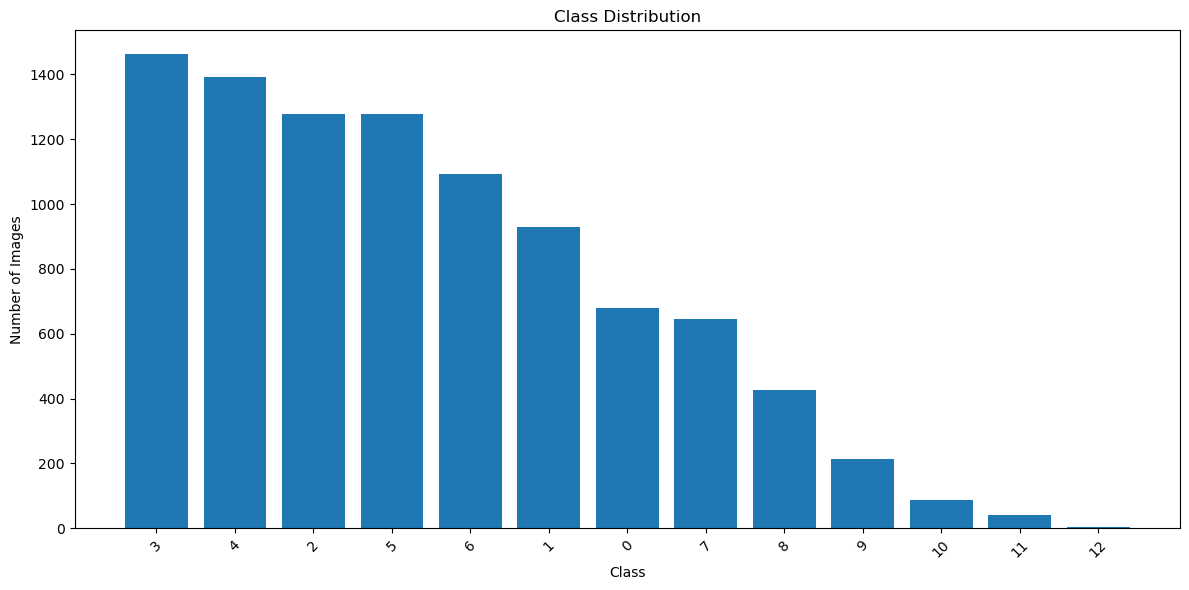

In [36]:
dataset_manager.plot_class_distribution()

### First Execution: Top 5 classes with highest probabilities


In [ ]:
initial_classes = dataset_manager.get_class_subset(num_classes=8)
data_split = dataset_manager.prepare_data_split(initial_classes)

INFO:__main__:Collected 1463 images for class 3
INFO:__main__:Collected 1391 images for class 4
INFO:__main__:Collected 1279 images for class 2
INFO:__main__:Collected 1278 images for class 5
INFO:__main__:Collected 1094 images for class 6
INFO:__main__:Collected 929 images for class 1
INFO:__main__:Collected 680 images for class 0
INFO:__main__:Split sizes - Train: 5679, Val: 1217, Test: 1218


In [38]:
train_gen, val_gen, test_gen = data_generator.create_generators(data_split)

INFO:__main__:Training set class distribution:
class
3    1243
4    1182
2    1087
5    1086
6     930
1     790
0     578
Name: count, dtype: int64


#### Calculating Class Weights


In [39]:
total_samples = sum(dataset_manager.class_counts[cls] for cls in initial_classes)

class_weights = {
    data_split.class_mapping[cls]: total_samples
    / (len(initial_classes) * dataset_manager.class_counts[cls])
    for cls in initial_classes
}

In [40]:
steps_per_epoch, validation_steps = data_generator.get_steps()
logger.info(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")

INFO:__main__:Steps per epoch: 215, Validation steps: 38


#### Initial Model


In [41]:
model = model_manager.build_model(data_generator.get_num_classes())
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MobileNetV3Large    │ (None, 7, 7, 960) │  2,996,352 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 960)       │          0 │ MobileNetV3Large… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 960)       │          0 │ MobileNetV3Large… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1920)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    983,040 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_41       │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ activation_41[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    131,328 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 7)         │      1,799 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,114,567 (15.70 MB)

 Trainable params: 1,117,191 (4.26 MB)

 Non-trainable params: 2,997,376 (11.43 MB)

In [42]:
history = model_manager.train(
    train_gen,
    val_gen,
    iteration=1,
    epochs=100,
    class_weights=class_weights,
)

Epoch 1/100


  2/216 ━━━━━━━━━━━━━━━━━━━━ 26s 125ms/step - accuracy: 0.1875 - loss: 2.6567

E0000 00:00:1731019199.840255   88371 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731019200.046631   88371 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


215/216 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2417 - loss: 2.0980

E0000 00:00:1731019212.231336   88373 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731019212.444141   88373 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_accuracy improved from -inf to 0.48480, saving model to saved_models/best_model_iter_1.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 36s 108ms/step - accuracy: 0.2422 - loss: 2.0951 - val_accuracy: 0.4848 - val_loss: 1.2100 - learning_rate: 1.0000e-04
Epoch 2/100
213/216 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4038 - loss: 1.3743
Epoch 2: val_accuracy improved from 0.48480 to 0.55053, saving model to saved_models/best_model_iter_1.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.4039 - loss: 1.3738 - val_accuracy: 0.5505 - val_loss: 1.0731 - learning_rate: 1.0000e-04
Epoch 3/100
212/216 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4675 - loss: 1.1896
Epoch 3: val_accuracy improved from 0.55053 to 0.57765, saving model to saved_models/best_model_iter_1.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.4676 - loss: 1.1893 - val_accuracy: 0.5776 - val_loss: 1.0072 - learning_rate: 1.0000e-04
Epoch 4/100
212/216 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc

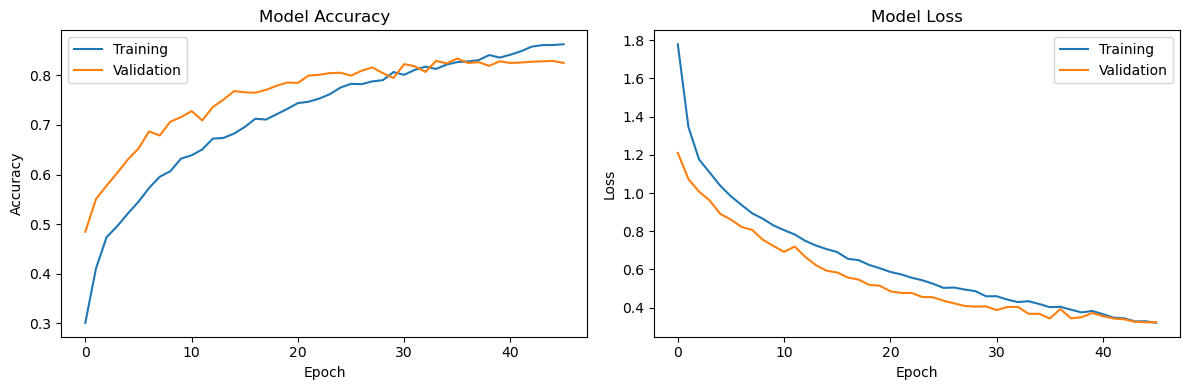

In [43]:
plot_history_subplot(history)

In [47]:
history_finetune = model_manager.fine_tune(
    train_gen,
    val_gen,
    iteration=1,
    num_layers_to_unfreeze=50,
    epochs=30,
    class_weights=class_weights,
)

INFO:__main__:Loaded best model from iteration 1


Epoch 1/30
213/216 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8429 - loss: 0.3810
Epoch 1: val_accuracy improved from -inf to 0.82827, saving model to saved_models/best_model_iter_1_ft.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.8429 - loss: 0.3808 - val_accuracy: 0.8283 - val_loss: 0.3433 - learning_rate: 1.0000e-06
Epoch 2/30
213/216 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8552 - loss: 0.3602
Epoch 2: val_accuracy did not improve from 0.82827
216/216 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8551 - loss: 0.3602 - val_accuracy: 0.8274 - val_loss: 0.3435 - learning_rate: 1.0000e-06
Epoch 3/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8416 - loss: 0.3690
Epoch 3: val_accuracy improved from 0.82827 to 0.82909, saving model to saved_models/best_model_iter_1_ft.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8417 - loss: 0.3690 - val_accuracy: 0.8291 - val_loss: 0.3429 - learning_rate: 1.0000e-06
Epoch 4/30
215/216 ━━━━━━━━

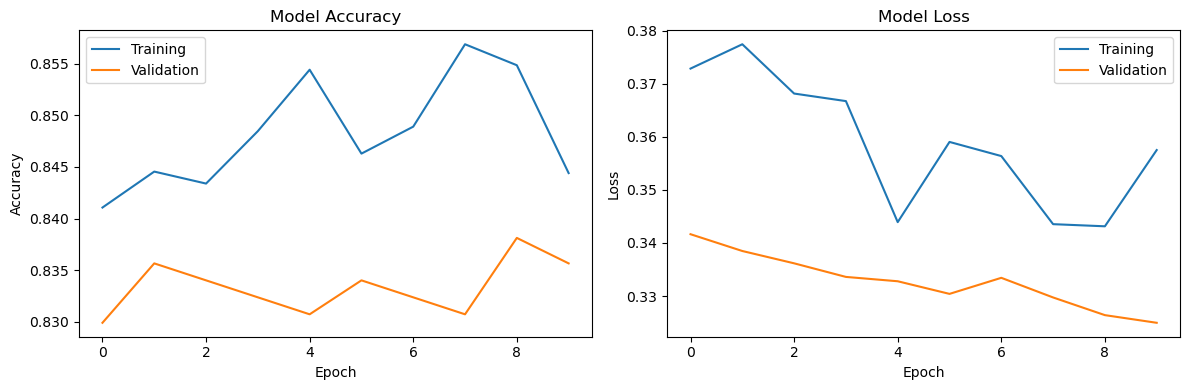

In [45]:
plot_history_subplot(history_finetune)

In [46]:
model_manager.prepare_next_iteration(previous_iteration=1, new_num_classes=8)

INFO:__main__:Loaded best model from iteration 1_ft


#### Second Iteration: The next classes with highest probabilities
